

#  Insight Health Data - Boston 
## Project: Establish gestational age by whole blood gene expression level



**Wenqin Hu**<br/>
**Summer 2019**<br/>



<hr style="height:2pt">

### Overview
>

A basic need in pregnancy care is to establish gestational age. All widely-used fetal growth standards imply knowledge of gestational age at assessment, and inaccurate estimates may lead to unnecessary interventions and sub-optimal patient management. Current approaches to establish gestational age rely on patient’s recollection of her last menstrual period and/or ultrasound, with the latter being not only costly but also less accurate if not performed during the first trimester of pregnancy. Therefore development of an inexpensive and accurate molecular clock of pregnancy would be of benefit to patients and health care systems.
>
 
While maternal blood proteins and mRNAs were previously reported to change systematically with gestational age in normal pregnancy, it is not known how accurately the maternal whole blood transcriptome can predict the gestational age at blood draw in both normal and complicated pregnancies. Of particular interest is to determine the best computational approach to use genome-wide level expression data to capture the transcriptomics clock of pregnancy. 

In [13]:
#PLEASE RUN THIS CELL 
import gc
import requests
import os
import glob
import json
import h5py
import pickle

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib import pyplot
import numpy as np
import pandas as pd
import random

from numpy import median


from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, scale 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import r2_score, log_loss, accuracy_score, mean_squared_error
from sklearn import model_selection
from sklearn.ensemble import IsolationForest

from IPython.display import Image
import seaborn as sns

import time

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingClassifier

from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.utils import resample

from math import sqrt
from scipy.stats import ttest_ind
from scipy.ndimage.filters import gaussian_filter1d

import warnings
warnings.filterwarnings("ignore")

from google.colab import files

from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

#### location of data

In [2]:
# When using Colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
folder = '/content/gdrive/My Drive/Colab/Insight/pre-project/DREAM_Preterm_Birth_Prediction/'
subfolder = 'data/used_0619/'

Mounted at /content/gdrive


In [0]:
# When using locally
#folder = ''
#subfolder = '/data/'

#### functions

In [0]:
def RMSE(y_actual, y_predicted): 
    return  round(sqrt(mean_squared_error(y_actual, y_predicted)),2)
  
  
def model_perfomance(model, X_train, y_train, X_test, y_test):
    print('train score:', round(model.score(X_train, y_train),2))
    print('test score:', round(model.score(X_test, y_test),2))

    predict_train = model.predict(X_train)
    predict_test = model.predict(X_test)
    
    rmse = RMSE(y_test, predict_test)

    # plot model prediction
    # draw an figure for ultrasound accuracy
    us_acc = [[6,45],[5,40],[4,35]]

    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(y_train,predict_train,label ='train')
    ax.scatter(y_test,predict_test,label = 'test',c='red')
    ax.plot(us_acc[1],us_acc[0],c='orange',label ='ultrasound: 95% conf')
    ax.plot(us_acc[1],us_acc[2],c='orange')
    ax.text(32, 14, 'Test set', fontsize = 14)
    ax.text(32, 12, 'RMSE = '+ str(rmse), fontsize = 14)
    ax.text(32, 10, 'R2 = '+ str(round(model.score(X_test, y_test),2)), fontsize = 14)
    ax.set_xlabel('Real GA', fontsize = 14)
    ax.set_ylabel('Predict GA', fontsize = 14)
    ax.set_xlim(5,45)
    ax.set_ylim(5,45)
    ax.legend()
    
    
def plot_CV_result():
    # Plot 10-fold CV results
    plt.plot(tuning_factors, train_rmse, label = 'train')
    plt.fill_between(tuning_factors, np.asarray(train_rmse)+np.asarray(train_std_rmse), np.asarray(train_rmse)-np.asarray(train_std_rmse), alpha=0.2)
    plt.plot(tuning_factors, test_rmse, label = 'test')
    plt.fill_between(tuning_factors, np.asarray(test_rmse)+np.asarray(test_std_rmse), np.asarray(test_rmse)-np.asarray(test_std_rmse), alpha=0.2)
    plt.legend()
    plt.xlabel('Number of tuning factor')
    plt.ylabel('RMSE')
    plt.title('GA')
    plt.axvline(x = tuning_factors[np.argmin(test_rmse)],ls = '--')
 
    print ('minimal at: ', tuning_factors[np.argmin(test_rmse)], ' minimal test rmse: ', np.min(test_rmse).round(2))
    
    
def train_record_CV_result():
    cv_results = cross_validate(model, X, y, cv=10, return_train_score= True, scoring='neg_mean_squared_error')
    train_rmse_tmp = [sqrt(-1*x) for x in cv_results['train_score']]
    test_rmse_tmp = [sqrt(-1*x) for x in cv_results['test_score']]
    
    train_rmse.append(np.mean(train_rmse_tmp))
    test_rmse.append(np.mean(test_rmse_tmp))
    train_std_rmse.append(np.std(train_rmse_tmp))
    test_std_rmse.append(np.std(test_rmse_tmp))

### EXPLORE DATASET

#### Read the df and label file 


In [0]:
# Reading the dream_gene_GA
with open (folder + subfolder + 'dream_GSE_GA.csv', 'rb') as fp:
    GA = pickle.load(fp)

# reading GSE_gene_probe_nor_T
with open (folder + subfolder + 'GSE_gene_probe_T.csv', 'rb') as fp:
    GSE_gene_probe_T = pickle.load(fp)

# reading dream_gene_probe_train_T
with open (folder + subfolder + 'dream_gene_probe_T.csv', 'rb') as fp:
    dream_gene_probe_T = pickle.load(fp)

#concatenate GSE and Dream (can not save > 4 GB)
df = pd.concat([dream_gene_probe_T, GSE_gene_probe_T])
del (dream_gene_probe_T, GSE_gene_probe_T)


In [0]:
# remove outliear
with open (folder + subfolder + 'outlier_list.txt', 'rb') as fp:
    outlier_list = pickle.load(fp)
useable_list = [x for x in range(len(GA)) if x not in outlier_list]    # pred_if_list
GA = GA[useable_list]
df = df.iloc[useable_list,:]

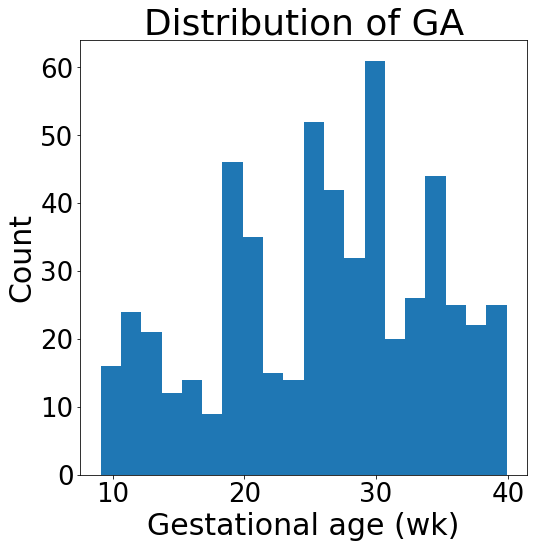

In [6]:
# explore GA
# visualize the histogram GA
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

ax.hist(GA,bins = 20)
ax.set_xlabel('Gestational age (wk)', fontsize = 30)
ax.set_ylabel('Count', fontsize = 30)
ax.set_title('Distribution of GA', fontsize = 36);

ax.xaxis.set_tick_params(labelsize=26)
ax.yaxis.set_tick_params(labelsize=26)

#print(GA.shape, df.shape)
fig.savefig(folder + 'figure/'+'GA_distribution.png')

#### group by

In [0]:
# for the limitation of RAM, use 5 subset of df to get the group df, then concat together

sub_columns = [0,200000,400000,600000,800000,df.shape[1]]
for i in range(5):
    df_sub = df.iloc[:,sub_columns[i]:sub_columns[i+1]]
    df_sub['GA'] = GA.round() 
    df_sub_group = df_sub.groupby(['GA']).mean()
    vars()['df_sub_group_'+str(i)] = df_sub_group.copy()
    print(vars()['df_sub_group_'+str(i)].shape)

df_group = pd.concat([df_sub_group_0,df_sub_group_1,df_sub_group_2,df_sub_group_3,df_sub_group_4], axis=1)
print(df_group.shape)

del(df_sub)

(32, 200000)
(32, 200000)
(32, 200000)
(32, 200000)
(32, 157862)
(32, 957862)


In [0]:
with open(folder + subfolder + 'df_group.csv', 'wb') as fp:
    pickle.dump(df_group, fp)

In [0]:
with open (folder + subfolder + 'df_group.csv', 'rb') as fp:
    df_group = pickle.load(fp)

#### Explore group by data

In [0]:
%%time
# get cor GA from full X and y and save
cor_GA = [np.corrcoef(GA, df.iloc[:,i].values.tolist())[0][1] for i in range(df.shape[1])]

# get cor GA from grouped X and y
group_cor_GA = [np.corrcoef(df_group.index, df_group.iloc[:,i].values.tolist())[0][1] for i in range(df_group.shape[1])]

# get slope of features and GA
slopes = [LinearRegression().fit((np.array(GA)).reshape(-1, 1),df.iloc[:,i]).coef_[0] for i in range(df_group.shape[1])]

In [0]:
# save cor GA and group cor GA
with open(folder+ subfolder + 'cor_GA_gene_probe.txt', 'wb') as fp:
    pickle.dump(cor_GA, fp)
    
with open(folder+ subfolder + 'group_cor_GA_gene_probe.txt', 'wb') as fp:
    pickle.dump(group_cor_GA, fp)    

with open(folder+ subfolder + 'slopes.txt', 'wb') as fp:
    pickle.dump(slopes, fp)    

In [0]:
# read cor GA and group cor GA and slope
with open (folder+ subfolder + 'cor_GA_gene_probe.txt', 'rb') as fp:
    cor_GA = pickle.load(fp) 
    
with open (folder+ subfolder + 'group_cor_GA_gene_probe.txt', 'rb') as fp:
    group_cor_GA = pickle.load(fp)   
    
with open (folder+ subfolder + 'slopes.txt', 'rb') as fp:
    slopes = pickle.load(fp) 

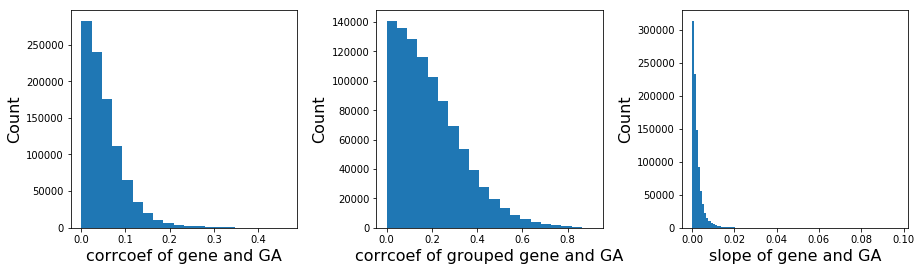

In [0]:
# visualize the histogram of corrcoef of probe_gene and GA
fig, ax = plt.subplots(1,3)
fig.set_size_inches(15,4)
fig.subplots_adjust(hspace=0.35,wspace=0.35)

ax[0].hist([abs(x) for x in cor_GA],bins = 20)
ax[0].set_xlabel('corrcoef of gene and GA', fontsize = 16)
ax[0].set_ylabel('Count', fontsize = 16)

ax[1].hist([abs(x) for x in group_cor_GA],bins = 20)
ax[1].set_xlabel('corrcoef of grouped gene and GA', fontsize = 16)
ax[1].set_ylabel('Count', fontsize = 16)

ax[2].hist([abs(x) for x in slopes],bins = 100)
ax[2].set_xlabel('slope of gene and GA', fontsize = 16)
ax[2].set_ylabel('Count', fontsize = 16);

fig.savefig(folder + 'figure/' + 'corrcoef.png')

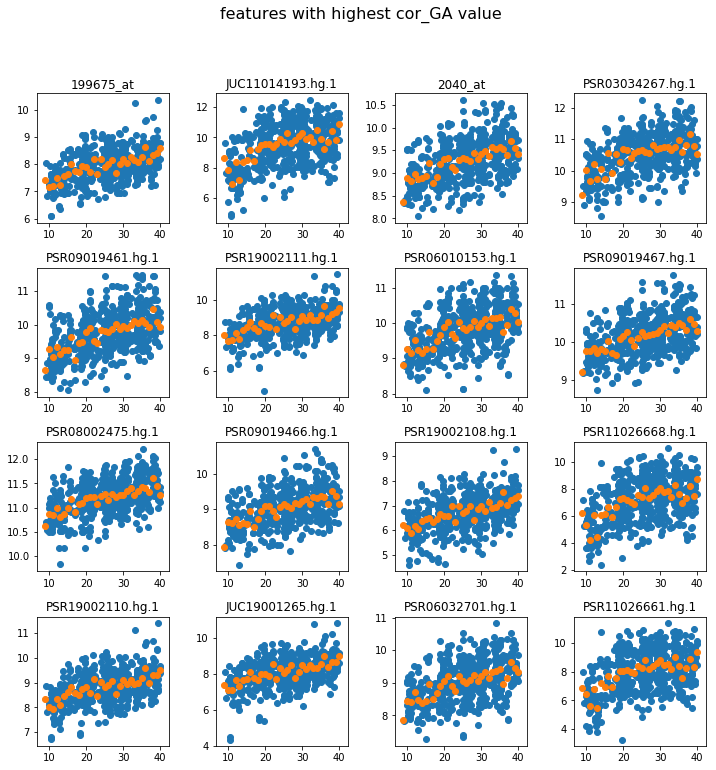

In [0]:
# visualize the high group_car_GA
order = np.argsort([-abs(x) for x in cor_GA])                
                              
fig, ax = plt.subplots(4,4)
fig.set_size_inches(12, 12)
fig.subplots_adjust(hspace=0.35,wspace=0.35)

k = 0
for i in range(4):
    for j in range(4):
        tmp = order[k]
        ax[j,i].scatter(GA, df.iloc[:,tmp])
        ax[j,i].scatter(df_group.index, df_group.iloc[:,tmp])
        ax[j,i].scatter
        ax[j,i].set_title(df.columns[tmp])
        k = k +1

fig.suptitle('features with highest cor_GA value',fontsize = 16);

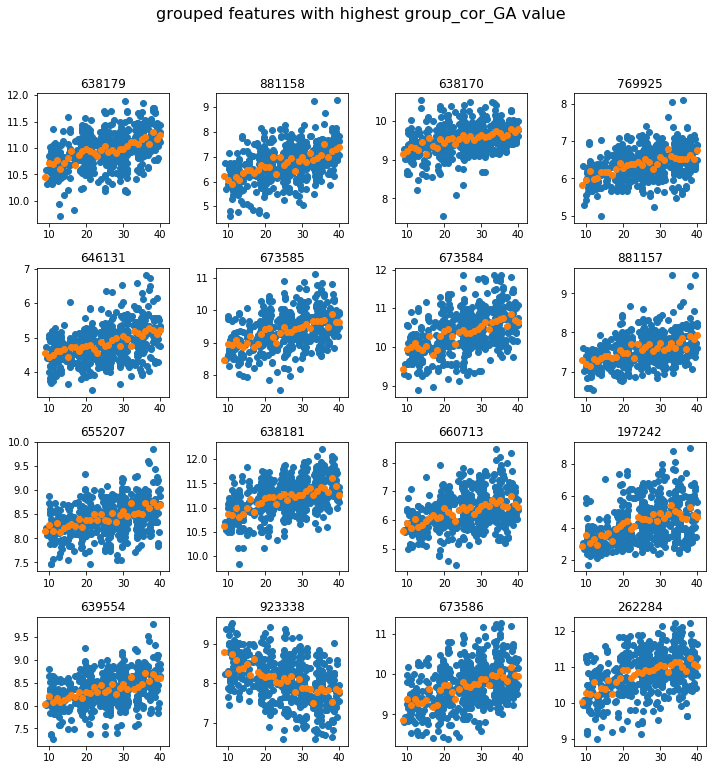

In [0]:
# visualize the high group_car_GA
order = np.argsort([-abs(x) for x in group_cor_GA])                
                              
fig, ax = plt.subplots(4,4)
fig.set_size_inches(12,12)
fig.subplots_adjust(hspace=0.35,wspace=0.35)

k = 0
for i in range(4):
    for j in range(4):
        tmp = order[k]
        ax[j,i].scatter(GA, df.iloc[:,tmp])
        ax[j,i].scatter(df_group.index, df_group.iloc[:,tmp])
        ax[j,i].set_title(str(tmp))
        k = k +1

fig.suptitle('grouped features with highest group_cor_GA value',fontsize = 16);

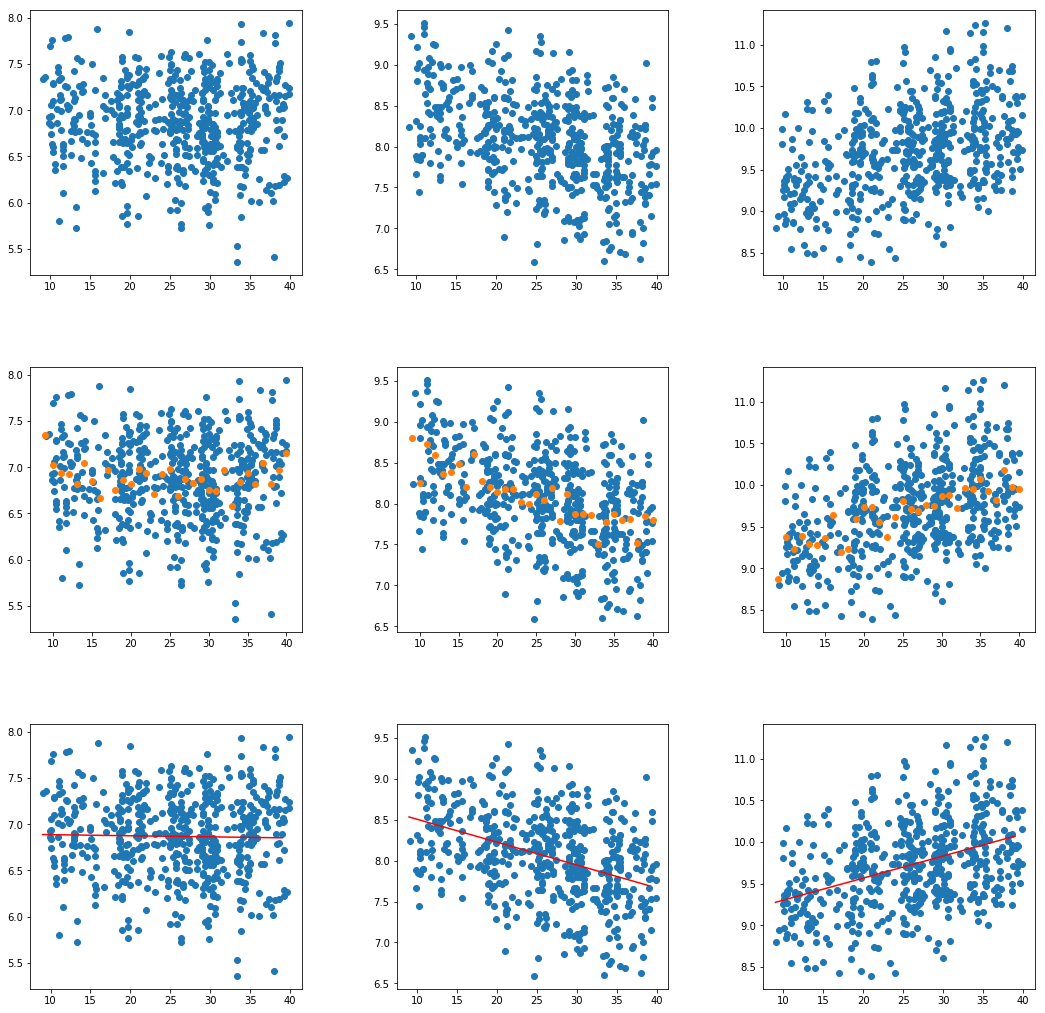

In [0]:
# visualize the examples                
                              
fig, ax = plt.subplots(3,3)
fig.set_size_inches(18,18)
fig.subplots_adjust(hspace=0.35,wspace=0.35)

example_list = [295833,923338,673586]

k = 0

for i in range(3):
    tmp = order[k]
    ax[0,i].scatter(GA, df.iloc[:,example_list[k]])
    
    ax[1,i].scatter(GA, df.iloc[:,example_list[k]])
    ax[1,i].scatter(df_group.index, df_group.iloc[:,example_list[k]])
     
    ax[2,i].scatter(GA, df.iloc[:,example_list[k]])
    ax[2,i].plot(range(9,40),LinearRegression().fit(np.array(GA).reshape(-1,1), df.iloc[:,example_list[k]]).predict(np.array(range(9,40)).reshape(-1,1)), c = 'red')
    #ax[j,i].xaxis.set_tick_params(labelsize=14)
    #ax[j,i].yaxis.set_tick_params(labelsize=14)
    k = k + 1


fig.savefig(folder + 'figure/'+'feature_selection.png')

### select features


selected features:  15498 14561


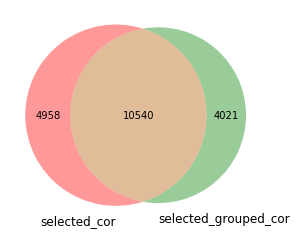

In [11]:
# new df_train with high corrcoef gene only
cor_threshold = 0.195
group_cor_threshold = 0.6

select_cor = [abs(x) > cor_threshold for x in cor_GA]
select_group_cor = [abs(x) > group_cor_threshold for x in group_cor_GA]
print('selected features: ', sum(select_cor),sum(select_group_cor))

plt = venn2([set(df.columns[select_cor]), set(df.columns[select_group_cor])], set_labels = ('selected_cor', 'selected_grouped_cor'))
 

pyplot.savefig(folder + 'figure/'+'feature_selection_b.png')

In [12]:
#  use group cor GA 
# new df_train with both high corrcoef and group corrcoef
select = [(abs(group_cor_GA[i]) > group_cor_threshold and abs(cor_GA[i]) > cor_threshold) for i in range(len(cor_GA))]

print('selected features: ', sum(select))

X = df.iloc[:,select]
y = GA

print(X.shape, y.shape)

selected features:  10540
(555, 10540) (555,)


### model selection

processing... 1    used(s)... 3.3652679920196533
processing... 11    used(s)... 14.50300407409668
processing... 21    used(s)... 33.243844509124756
processing... 31    used(s)... 59.215230226516724
processing... 41    used(s)... 93.2089786529541
processing... 51    used(s)... 135.22866415977478
processing... 61    used(s)... 184.91660714149475
processing... 71    used(s)... 241.90839004516602
processing... 81    used(s)... 306.2793564796448
processing... 91    used(s)... 377.1650149822235
minimal at:  41  minimal test rmse:  2.97
CPU times: user 4min 28s, sys: 7min 52s, total: 12min 20s
Wall time: 6min 17s


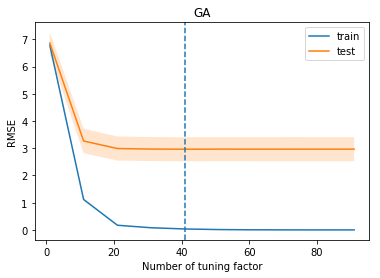

In [0]:
%%time
# 10-fold CV, with shuffle
start_time = time.time()
train_rmse,train_std_rmse,test_rmse,test_std_rmse = [],[],[],[]

tuning_factors = np.arange(1, 100, 10)

for i in tuning_factors:
    model = PLSRegression(n_components=i)
    train_record_CV_result()
    print('processing...',i, '   used(s)...', time.time()-start_time)
    
plot_CV_result() 

processing... 0.001    used(s)... 4.344810247421265
processing... 0.005    used(s)... 7.351129531860352
processing... 0.01    used(s)... 9.854656457901001
processing... 0.05    used(s)... 12.370903730392456
processing... 0.1    used(s)... 14.917535066604614
processing... 0.5    used(s)... 17.472352981567383
processing... 1    used(s)... 20.01611351966858
processing... 5    used(s)... 22.550248384475708
processing... 10    used(s)... 25.03808069229126
processing... 50    used(s)... 27.54096484184265
processing... 100    used(s)... 30.062846183776855
processing... 500    used(s)... 32.56224751472473
minimal at:  0.001  minimal test rmse:  2.69


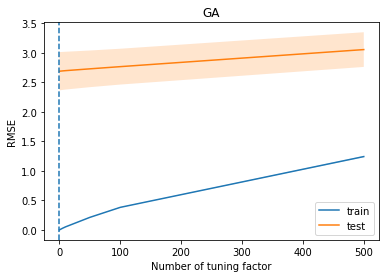

In [0]:
# 10-fold CV, with shuffle
start_time = time.time()

train_rmse,train_std_rmse,test_rmse,test_std_rmse = [],[],[],[]
scale_X = scale(X)

tuning_factors = [.001,.005,.01,.05,.1,.5,1,5,10,50,100,500]
for i in tuning_factors:
    model = Ridge(alpha = i)
    train_record_CV_result()
    print('processing...',i, '   used(s)...', time.time()-start_time)
    
plot_CV_result() 

processing... 0.0001    used(s)... 35.930739641189575
processing... 0.0005    used(s)... 67.90279412269592
processing... 0.001    used(s)... 97.27285933494568
processing... 0.005    used(s)... 127.1479971408844
processing... 0.01    used(s)... 156.55451703071594
processing... 0.05    used(s)... 184.34202098846436
processing... 0.1    used(s)... 211.59715723991394
minimal at:  0.0005  minimal test rmse:  3.24


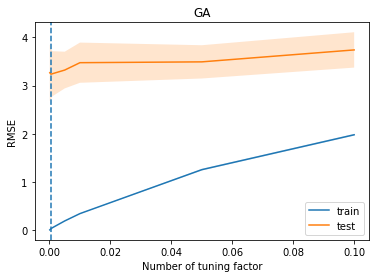

In [0]:

# 10-fold CV, with shuffle
start_time = time.time()

train_rmse,train_std_rmse,test_rmse,test_std_rmse = [],[],[],[]
scale_X = scale(X)

tuning_factors = [0.0001,0.0005,.001,.005,.01,.05,.1]

for i in tuning_factors:
    model = Lasso(alpha = i)
    train_record_CV_result()
    print('processing...',i, '   used(s)...', time.time()-start_time)
    
plot_CV_result() 

### best models on training testing

In [14]:
# divide the index in to train and test with ratio 80:20
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(444, 10540) (111, 10540) (444,) (111,)


#### PLS

train score: 1.0
test score: 0.92
features:  [10540]


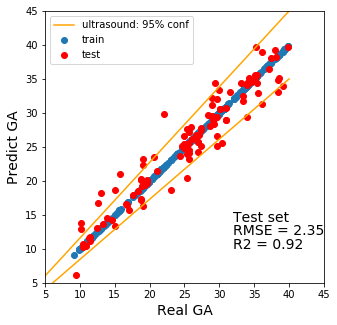

In [0]:
# pls model
model = PLSRegression(n_components=40).fit(X_train, y_train)
model_perfomance(model,X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)

print('features: ',sum(model.coef_  != 0))

#### Ridge

train score: 1.0
test score: 0.89
features:  10540


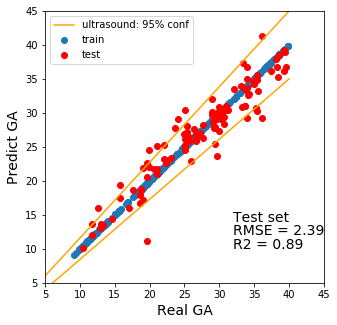

In [0]:
# pls model
model = Ridge(alpha = 1).fit(X_train, y_train)
#model = RidgeCV(cv=5).fit(X_train, y_train)
model_perfomance(model,X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)

print('features: ',sum(model.coef_ != 0))

#### Lasso

train score: 1.0
test score: 0.85
features:  772


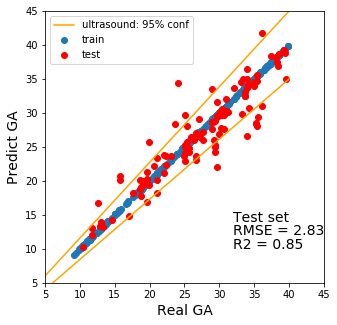

In [0]:
# lasso model
model = Lasso(alpha = .001).fit(X_train, y_train)
#model = LassoCV(cv=5).fit(X_train, y_train)
model_perfomance(model,X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)

print('features: ',sum(model.coef_ != 0))

train score: 0.94
test score: 0.53


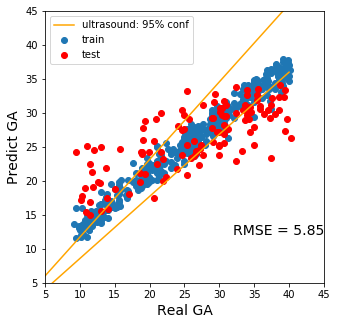

In [0]:
## RF
model = RandomForestRegressor(n_estimators=200).fit(X_train, y_train)
model_perfomance(model,X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)


In [0]:
# Training classifiers
reg1 = PLSRegression(n_components=40)
reg2 = Lasso(alpha = 0.01)
reg3 = Ridge(alpha = 1)
model = VotingRegressor(estimators=[('PLS', reg1), ('Lasso', reg2), ('Ridge', reg3)])
model = model.fit(X_train, y_train)

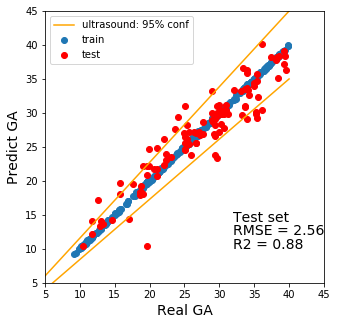

In [0]:
predict_train = [model.predict(np.array(X_train.iloc[i,:]).ravel().reshape(1, -1)) for i in range(X_train.shape[0])]
predict_test = [model.predict(np.array(X_test.iloc[i,:]).ravel().reshape(1, -1)) for i in range(X_test.shape[0])]

rmse = RMSE(y_test, predict_test)

# plot model prediction
# draw an figure for ultrasound accuracy
us_acc = [[6,45],[5,40],[4,35]]

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_train,predict_train,label ='train')
ax.scatter(y_test,predict_test,label = 'test',c='red')
ax.plot(us_acc[1],us_acc[0],c='orange',label ='ultrasound: 95% conf')
ax.plot(us_acc[1],us_acc[2],c='orange')
ax.text(32, 14, 'Test set', fontsize = 14)
ax.text(32, 12, 'RMSE = '+ str(rmse), fontsize = 14)
ax.text(32, 10, 'R2 = '+ str(round(r2_score(y_test,predict_test),2)), fontsize = 14)
ax.set_xlabel('Real GA', fontsize = 14)
ax.set_ylabel('Predict GA', fontsize = 14)
ax.set_xlim(5,45)
ax.set_ylim(5,45)
ax.legend()
    

## prediction and stat


### left one out

In [0]:
def left_one_out(X=X, y=y):
    test_index = i
    train_index = [x for x in range(len(y)) if x != test_index]

    X_train = X.iloc[train_index,:]
    X_test = X.iloc[test_index,:]
    y_train = y[train_index]
    y_test = y[test_index]
    sample_ID_test = X.index[test_index]
    return X_train, np.array(X_test).reshape(1, -1), y_train, y_test, sample_ID_test

In [0]:
%%time
start_time = time.time()
# pls model, select outlier
predict_GA = []
real_GA = []
sample_ID = []

model = PLSRegression(n_components = 40)  

for i in range(len(y)):   
    X_train, X_test, y_train, y_test, sample_ID_test = left_one_out(X=X, y=y)

    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    predict_GA = predict_GA + y_predict.tolist()[0]
    real_GA = real_GA + [y_test]
    sample_ID = sample_ID + [sample_ID_test]
    
    if i%10 == 0: print('processing...',i, '   used(s)...', time.time()-start_time)

    left_one_out_PLS = pd.DataFrame(list(zip(sample_ID,real_GA,predict_GA)), 
                                columns =['sample_ID','real_GA','predict_GA'])



In [0]:
with open(folder + subfolder + 'left_one_out_PLS_565.csv', 'wb') as fp:
    pickle.dump(left_one_out_PLS, fp)  
left_one_out_PLS.shape

(565, 3)

In [0]:
with open (folder + subfolder + 'left_one_out_PLS_565.csv', 'rb') as fp:
    left_one_out_PLS = pickle.load(fp)

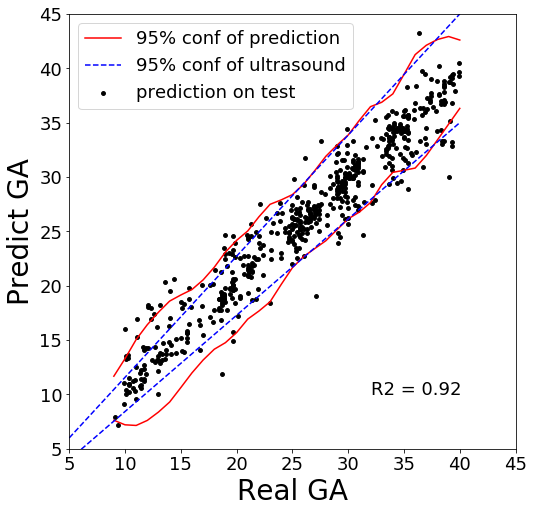

In [0]:
predict_result_df = left_one_out_PLS

predict_result_df ['round_real_GA']  = round(predict_result_df ['real_GA'])
mean_tmp = predict_result_df .groupby(['round_real_GA']).mean()['real_GA']
std_tmp = predict_result_df .groupby(['round_real_GA'])['predict_GA'].std()

# plot model prediction
# draw an figure for ultrasound accuracy
us_acc = [[6,45],[5,40],[4,35]]

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(predict_result_df ['real_GA'], predict_result_df ['predict_GA'],label ='prediction on test',c='black',s=15)

ax.plot(mean_tmp.index,gaussian_filter1d((mean_tmp+1.96*std_tmp), sigma=1), c = 'red', label = '95% conf of prediction')
ax.plot(mean_tmp.index,gaussian_filter1d((mean_tmp-1.96*std_tmp), sigma=1), c = 'red')

ax.plot(us_acc[1],us_acc[0],c='blue',label ='95% conf of ultrasound', ls ='--')
ax.plot(us_acc[1],us_acc[2],c='blue', ls = '--')


ax.text(32, 10, 'R2 = 0.92 ',fontsize = 18)

ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
ax.set_xlabel('Real GA', fontsize = 28)
ax.set_ylabel('Predict GA', fontsize = 28)
ax.set_xlim(5,45)
ax.set_ylim(5,45)
ax.legend(fontsize = 18);


plt.savefig(folder + 'figure/'+'model_1.png')

#### left one out lasso

In [0]:
# select feature by Lasso_coef_list
X_lasso = X.iloc[:,Lasso_coef_list]
y_lasso = y

In [0]:
%%time
start_time = time.time()
# pls model, select outlier
predict_GA = []
real_GA = []
sample_ID = []

model = Lasso(alpha = 0.01)

for i in range(len(y)):   
    if i%10 == 0: print('processing...',i, '   used(s)...', time.time()-start_time)
    #X_train, X_test, y_train, y_test, sample_ID_test = left_one_out(X=X_lasso, y=y_lasso)
    X_train, X_test, y_train, y_test, sample_ID_test = left_one_out(X=X , y=y )

    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    predict_GA = predict_GA + [y_predict]
    real_GA = real_GA + [y_test]
    sample_ID = sample_ID + [sample_ID_test]
    

    left_one_out_Lasso = pd.DataFrame(list(zip(sample_ID,real_GA,predict_GA)), 
                                columns =['sample_ID','real_GA','predict_GA'])

In [0]:
with open(folder + subfolder + 'left_one_out_Lasso_565.csv', 'wb') as fp:
    pickle.dump(left_one_out_Lasso, fp)  

In [0]:
with open (folder + subfolder + 'left_one_out_Lasso_565.csv', 'rb') as fp:
    left_one_out_Lasso = pickle.load(fp)
    
left_one_out_Lasso.shape

(555, 4)

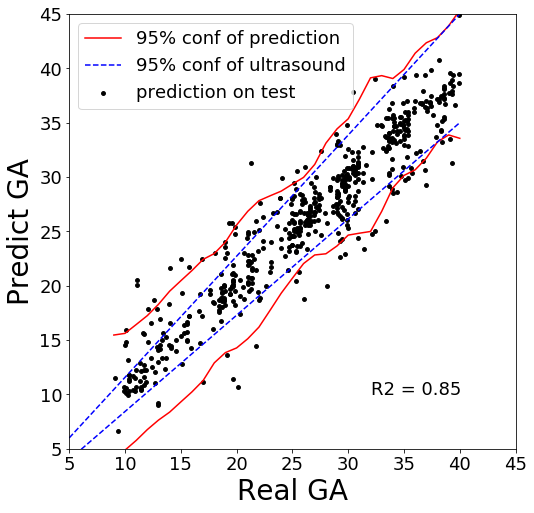

In [0]:
predict_result_df = left_one_out_Lasso

predict_result_df ['round_real_GA']  = round(predict_result_df ['real_GA'])
mean_tmp = predict_result_df .groupby(['round_real_GA']).mean()['real_GA']
std_tmp = predict_result_df .groupby(['round_real_GA'])['predict_GA'].std()

# plot model prediction
# draw an figure for ultrasound accuracy
us_acc = [[6,45],[5,40],[4,35]]

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(predict_result_df ['real_GA'], predict_result_df ['predict_GA'],label ='prediction on test',c='black',s=15)

ax.plot(mean_tmp.index,gaussian_filter1d((mean_tmp+1.96*std_tmp), sigma=1), c = 'red', label = '95% conf of prediction')
ax.plot(mean_tmp.index,gaussian_filter1d((mean_tmp-1.96*std_tmp), sigma=1), c = 'red')

ax.plot(us_acc[1],us_acc[0],c='blue',label ='95% conf of ultrasound', ls ='--')
ax.plot(us_acc[1],us_acc[2],c='blue', ls = '--')

ax.text(32, 10, 'R2 = 0.85 ',fontsize = 18)

ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
ax.set_xlabel('Real GA', fontsize = 28)
ax.set_ylabel('Predict GA', fontsize = 28)
ax.set_xlim(5,45)
ax.set_ylim(5,45)
ax.legend(fontsize = 18);


plt.savefig(folder + 'figure/'+'model_2.png')

### test feature selection by shuffle

train score: 0.94
test score: 0.78
features:  189


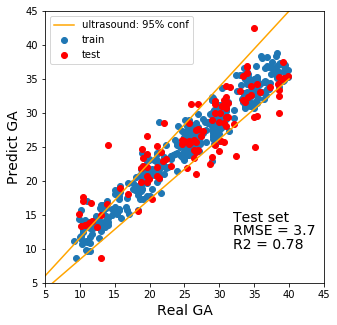

In [16]:
# lasso model
model = Lasso(alpha = .1).fit(X_train, y_train)
#model = LassoCV(cv=5).fit(X_train, y_train)
model_perfomance(model,X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test)

print('features: ',sum(model.coef_ != 0))

In [0]:
lasso_list = [i for i in range(X.shape[1]) if model.coef_[i] != 0]
X_train_0 = X_train.copy()
X_train_0.iloc[:,:] = 0
X_train_0.iloc[:,lasso_list] = X_train.iloc[:,lasso_list]

In [0]:
print('shuffle score:', round(model.score(X_train_0, y_train),2))


shuffle score: 0.85


### use lasso to refine biomarkers

In [0]:
# Lasso select biomarkers, Use all X,y
model = Lasso(alpha = .1).fit(X,y)
print('features: ',sum(model.coef_ != 0))
Lasso_coef_list = [i for i in range(len(model.coef_)) if model.coef_[i] != 0]
len(Lasso_coef_list)

features:  213


213

In [0]:
# list of probe names selected by lasso
Lasso_coef_list = [i for i in range(X.shape[1]) if model.coef_[i] != 0]
Lasso_select_name_list = X.columns[Lasso_coef_list]
lasso_select_columns = [i for i in range(df.shape[1]) if df.columns[i] in  Lasso_select_name_list]

In [0]:
#gene names of selected
# get probe_gene_df
prob_name_df = pd.read_csv(folder+subfolder+'eset_probeset_annotation_20190627.txt', sep="\t") 
print(prob_name_df.shape)

prob_name_select_list = [i for i in range(prob_name_df.shape[0]) if prob_name_df['probeset'][i] in  Lasso_select_name_list]
prob_name_lasso_select_df = prob_name_df.iloc[prob_name_select_list,:]
print(prob_name_lasso_select_df.shape)
prob_name_lasso_select_df.to_csv(folder+subfolder+'prob_name_lasso_select_df.csv')

(911590, 3)
(210, 3)


### save 100 example  

In [0]:
#save 100 example patient prediction 
prediction_web = left_one_out_PLS.iloc[100:200,:]
prediction_web['Patient_ID'] = [('patient_' + str(i) + ' (real GA = '  + str(prediction_web['real_GA'].iloc[i])+ ' wk)') for i in range(prediction_web.shape[0])]
prediction_web.index = range(100)
prediction_web.to_csv(folder + subfolder +'prediction_web.csv')

In [0]:
# save probes for 100 examples
feature_number = prob_name_lasso_select_df.shape[0]
probe_web = pd.DataFrame(columns = ['sample_ID','Patient_ID','Probe','Gene','Expression_level'], index = range(feature_number * 100))

k = 0
for i in range(100):
    probe_web.iloc[k*feature_number: (k+1)*feature_number,:] = np.array([[prediction_web['sample_ID'][i]]*feature_number,
                                                               [prediction_web['Patient_ID'][i]]*feature_number,
                                                               prob_name_lasso_select_df['probeset'],
                                                               prob_name_lasso_select_df['Gene'],
                                                               df.iloc[(100+i),lasso_select_columns[3:]]]).T
    k = k + 1
    
probe_web.to_csv(folder+subfolder +'probe_web.csv')